# Experiments


<br>

### Imports

In [2]:
import numpy as np
import pandas as pd

import copy
from tqdm import tqdm

from sklearn.inspection import permutation_importance
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from wpdhack import suite, data, feature

In [3]:
from IPython.display import JSON

import matplotlib.pyplot as plt

In [1]:
default_params = {
    'data_dir': '../data',
    'model_1': 'lightgbm.LGBMRegressor', 
    'model_2': 'lightgbm.LGBMRegressor',
    'model_1_kwargs': {
        'num_leaves': 50,
        'n_estimators': 100,
        'reg_lambda': 0.1
    },
    'model_2_kwargs': {
        'num_leaves': 50,
        'n_estimators': 100,
        'reg_lambda': 0.1
    },
    'data_kwargs': {
        'real_power_sub_dir': 'real_power',
        'weather_sub_dir': 'weather',
        'real_power_time_period': '_pre_september',
        'real_power_site': 'Staplegrove_CB905',
        'weather_sites': ['staplegrove'], # , 'mousehole'],
        'weather_grid_points': None,
        'weather_interpolate_method': 'interpolate',
        'use_target_delta': False
    },
    'y1_col': 'value_max',
    'y2_col': 'value_min',
    'split_kwargs': {
        'n_splits': 5, 
        'shuffle': False
    },
    'cols_subset': None, 
    'features_kwargs': {
        'features': ['temporal', 'dir_speed', 'lagged', 'demand', 'solar', 'roc'], 
        'feature_lags': {
            'value': [1, 2, 3, 4, 5, 6, 48, 96, 336],
            'solar_irradiance_staplegrove_1': [1, 2],
            # 'solar_irradiance_staplegrove_2': [1, 2],
            # 'solar_irradiance_staplegrove_3': [1, 2],
            # 'solar_irradiance_staplegrove_4': [1, 2],
            # 'solar_irradiance_staplegrove_5': [1, 2],
            'temperature_staplegrove_1': [1, 2],
            # 'temperature_staplegrove_2': [1, 2],
            # 'temperature_staplegrove_3': [1, 2],
            # 'temperature_staplegrove_4': [1, 2],
            # 'temperature_staplegrove_5': [1, 2]
        },
        'roc_features': {
            'value': 3
        },
        'sites': ['staplegrove'],
        'grid_points': None
    }
}

In [4]:
df_features, df_target = data.construct_baseline_features_target_dfs(default_params['data_dir'], **default_params['data_kwargs'])
df_features, df_target = feature.create_additional_features(df_features, df_target, **default_params['features_kwargs'])
df_features = feature.process_features(df_features, cols_subset=default_params['cols_subset'])

Wall time: 19.4 s


{'y1_rmse': 9.564830632306506,
 'y2_rmse': 10.61546968401076,
 'combined_rmse': 14.33432205518877,
 'skill_score': 0.46333919980844857}

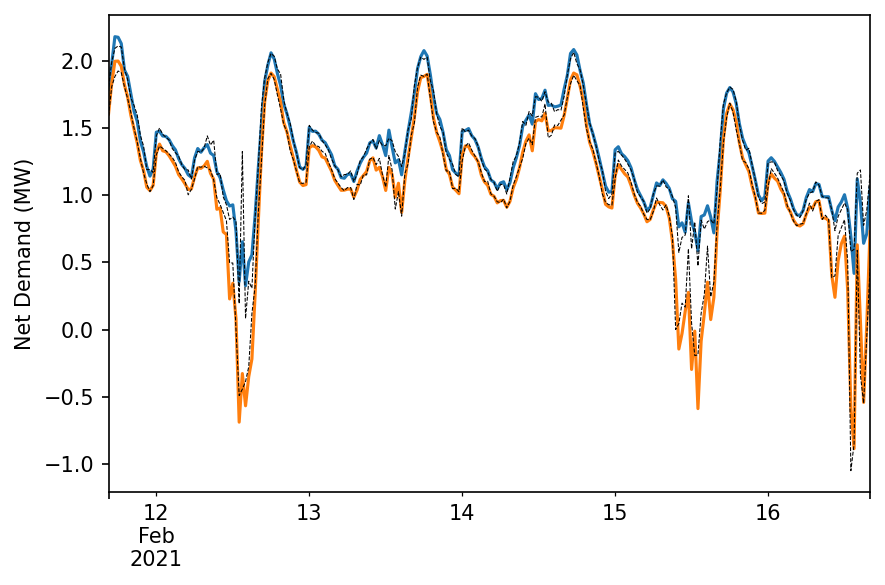

In [5]:
%%time

model_suite, error_metrics, df_pred, input_data = suite.run_parameterised_model(**default_params)
suite.plot_pred_sample(df_pred, df_target)

error_metrics

In [6]:
suite.calc_month_error_metrics(df_pred, df_target)

{'y1_rmse': 5.2648945808147305,
 'y2_rmse': 6.311222016002555,
 'combined_rmse': 8.218919532540008,
 'skill_score': 0.4331221002514892}

Wall time: 18.9 s


{'y1_rmse': 9.555973745611746,
 'y2_rmse': 10.637170039802408,
 'combined_rmse': 14.340931731709048,
 'skill_score': 0.4634306227782468}

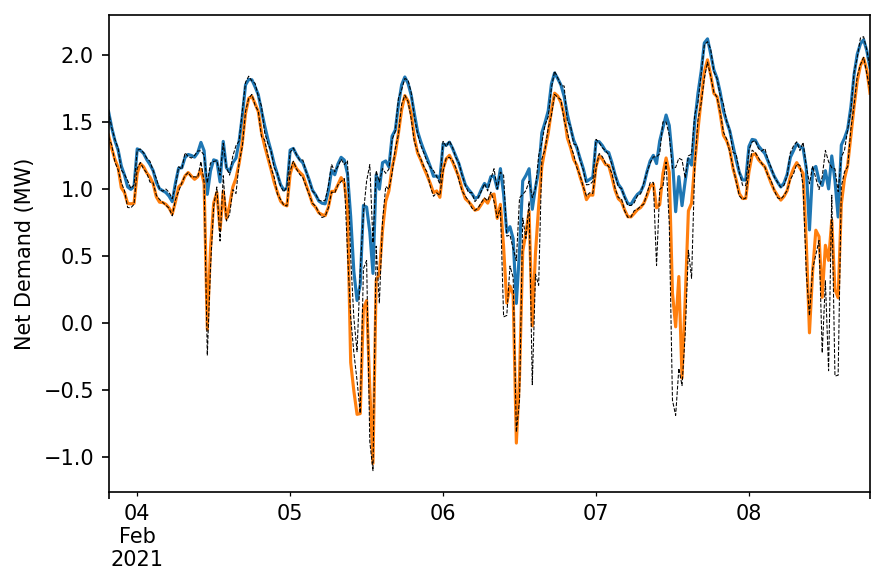

In [7]:
%%time

params = copy.deepcopy(default_params)

params['data_kwargs']['use_target_delta'] = True
model_suite, error_metrics, df_pred, input_data = suite.run_parameterised_model(**params)
suite.plot_pred_sample(df_pred, df_target)

error_metrics

In [8]:
suite.calc_month_error_metrics(df_pred, df_target)

{'y1_rmse': 5.311106286711871,
 'y2_rmse': 6.553212047332268,
 'combined_rmse': 8.435190461753137,
 'skill_score': 0.44451918459004125}

In [9]:
%%time 

# comparing the two wind speed encodings

params = copy.deepcopy(default_params)

params['cols_subset'] = ['value', 'temperature_staplegrove_1', 'solar_irradiance_staplegrove_1', 'pressure_staplegrove_1',
                         'spec_humidity_staplegrove_1', 'hour', 'doy', 'speed_staplegrove_1', 'direction_staplegrove_1', 'weekend', 'hcdh_staplegrove_1']
model_suite, error_metrics, df_pred, input_data = suite.run_parameterised_model(**params)
vectors_error = error_metrics['skill_score']

params['cols_subset'] = ['value', 'temperature_staplegrove_1', 'solar_irradiance_staplegrove_1', 'pressure_staplegrove_1', 'spec_humidity_staplegrove_1', 
                         'hour', 'windspeed_north_staplegrove_1', 'windspeed_east_staplegrove_1', 'doy', 'weekend', 'hcdh_staplegrove_1']
model_suite, error_metrics, df_pred, input_data = suite.run_parameterised_model(**params)
speed_dir_error = error_metrics['skill_score']

params['cols_subset'] = ['value', 'temperature_staplegrove_1', 'solar_irradiance_staplegrove_1', 'pressure_staplegrove_1', 'spec_humidity_staplegrove_1', 'speed_staplegrove_1', 
                         'direction_staplegrove_1', 'hour', 'windspeed_north_staplegrove_1', 'windspeed_east_staplegrove_1', 'doy', 'weekend', 'hcdh_staplegrove_1']
model_suite, error_metrics, df_pred, input_data = suite.run_parameterised_model(**params)
both_error = error_metrics['skill_score']


vectors_error, speed_dir_error, both_error

AssertionError: The following columns are missing: hcdh_staplegrove_1

In [10]:
%%time 

# comparing the local and utc hour features

params = copy.deepcopy(default_params)

params['cols_subset'] = ['value', 'temperature_staplegrove_1', 'solar_irradiance_staplegrove_1', 'pressure_staplegrove_1',
                         'spec_humidity_staplegrove_1', 'hour', 'doy', 'speed_staplegrove_1', 'direction_staplegrove_1', 'weekend', 'hcdh_staplegrove_1']
model_suite, error_metrics, df_pred, input_data = suite.run_parameterised_model(**params)
utc_hour_error = error_metrics['skill_score']

params['cols_subset'] = ['value', 'temperature_staplegrove_1', 'solar_irradiance_staplegrove_1', 'pressure_staplegrove_1', 'spec_humidity_staplegrove_1', 
                         'local_hour', 'windspeed_north_staplegrove_1', 'windspeed_east_staplegrove_1', 'doy', 'weekend', 'hcdh_staplegrove_1']
model_suite, error_metrics, df_pred, input_data = suite.run_parameterised_model(**params)
local_hour_error = error_metrics['skill_score']

params['cols_subset'] = ['value', 'temperature_staplegrove_1', 'solar_irradiance_staplegrove_1', 'pressure_staplegrove_1', 'spec_humidity_staplegrove_1', 
                         'hour', 'local_hour', 'windspeed_north_staplegrove_1', 'windspeed_east_staplegrove_1', 'doy', 'weekend', 'hcdh_staplegrove_1']
model_suite, error_metrics, df_pred, input_data = suite.run_parameterised_model(**params)
both_hours_error = error_metrics['skill_score']


utc_hour_error, local_hour_error, both_hours_error

AssertionError: The following columns are missing: hcdh_staplegrove_1

In [11]:
# investigating the impact of reduced training size

df_results = pd.DataFrame()
all_input_data = []
test_splits = list(range(2, 7))
params = copy.deepcopy(default_params)

for run_id, test_split in tqdm(enumerate(test_splits), total=len(test_splits)):    
    params['split_kwargs'] = {'n_splits': test_split, 'shuffle': False}
    model_suite, error_metrics, df_pred, input_data = suite.run_parameterised_model(**params)
    
    df_results = df_results.append(pd.DataFrame([error_metrics], index=[run_id]))
    all_input_data += [input_data]

df_results.index.name = 'run_id'
    
df_results

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:18<00:00, 15.70s/it]


,y1_rmse,y2_rmse,combined_rmse,skill_score
run_id,,,,
0,16.070170,17.000462,23.412705,0.469284
1,12.823515,13.854830,18.901101,0.467128
2,10.848084,11.768780,16.040679,0.467733
3,9.564831,10.615470,14.334322,0.463339
4,8.597028,9.512511,12.879309,0.463857


In [10]:
%%time

# tuning lightgbm params

params = copy.deepcopy(default_params)

params['model_1'] = 'lightgbm.LGBMRegressor'
params['model_2'] = 'lightgbm.LGBMRegressor'
params['model_1_kwargs'] = {
    'num_leaves': 50,
    'n_estimators': 100,
    'reg_lambda': 0.1
}
params['model_2_kwargs'] = {
    'num_leaves': 50,
    'n_estimators': 100,
    'reg_lambda': 0.1
}

model_suite, error_metrics, df_pred, input_data = suite.run_parameterised_model(**params)

error_metrics

Wall time: 7.46 s


{'y1_rmse': 10.394238059232482,
 'y2_rmse': 11.107258335853214,
 'combined_rmse': 15.255939156594394,
 'skill_score': 0.5131517932155136}

In [12]:
%%time

# tuning xgboost params

params = copy.deepcopy(default_params)

params['model_1'] = 'xgboost.XGBRegressor'
params['model_2'] = 'xgboost.XGBRegressor'
params['model_1_kwargs'] = {
    'max_depth': 3,
    'min_child_weight': 1,
    'eta': 0.2,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective':'reg:squarederror',
}
params['model_2_kwargs'] = {
    'max_depth': 3,
    'min_child_weight': 1,
    'eta': 0.2,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective':'reg:squarederror',
}

model_suite, error_metrics, df_pred, input_data = suite.run_parameterised_model(**params)

error_metrics

Wall time: 1min 16s


{'y1_rmse': 9.745429725376345,
 'y2_rmse': 10.978914644280096,
 'combined_rmse': 14.727131236598357,
 'skill_score': 0.4769702312458173}

In [13]:
suite.calc_month_error_metrics(df_pred, df_target) # 0.52872470 <- max_depth=3, eta=0.2

{'y1_rmse': 5.618842606018834,
 'y2_rmse': 6.5601102047367945,
 'combined_rmse': 8.637501845412501,
 'skill_score': 0.4551806262854375}

In [14]:
# assessing feature importance

model_1 = suite.load_module_attr(default_params['model_1'])(**default_params['model_1_kwargs'])
model_2 = suite.load_module_attr(default_params['model_2'])(**default_params['model_2_kwargs'])

model_1

LGBMRegressor(num_leaves=50, reg_lambda=0.1)

In [15]:
def clean_subsets(sfs):
    subsets = sfs.subsets_

    for idx, res in subsets.items():
        res['cv_scores'] = list(res['cv_scores'])

    return subsets

In [26]:
%%time

common_idxs = df_features.index.intersection(df_target.index)
df_features, df_target = df_features.loc[common_idxs], df_target.loc[common_idxs]

X, y = df_features.values, df_target['value_max'].values

sfs1 = SFS(model_1, 
           k_features=df_features.shape[1], 
           forward=True, 
           floating=False, 
           verbose=1,
           scoring='neg_mean_squared_error',
           cv=0)

sfs1 = sfs1.fit(X, y)

JSON(clean_subsets(sfs1))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:   29.6s finished
Features: 1/78[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:   26.3s finished
Features: 2/78[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:   25.8s finished
Features: 3/78[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   27.3s finished
Features: 4/78[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:   28.2s finished
Features: 5/78[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:   27.5s finished
Features: 6/78[Parallel(

Wall time: 40min 38s


<IPython.core.display.JSON object>

In [27]:
%%time

X, y = df_features.values, df_target['value_max'].values

sfs2 = SFS(model_1, 
           k_features=10, 
           forward=False, 
           floating=False, 
           verbose=1,
           scoring='neg_mean_squared_error',
           cv=0)

sfs2 = sfs2.fit(X, y)

JSON(clean_subsets(sfs2))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:  2.2min finished
Features: 77/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Wall time: 6min



STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

<IPython.core.display.JSON object>

In [29]:
%%time

X, y = df_features.values, df_target['value_max'].values
model_1.fit(X, y)

result = permutation_importance(
    model_1, X, y, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=df_features.columns)

forest_importances.sort_values(ascending=False)

Wall time: 3min 17s


value                                                      1.429007
value___ewm__alpha_0.9__mean                               0.078028
value_diff_2                                               0.006989
value_lag_1                                                0.005793
value___ewm__alpha_0.01__mean                              0.004561
                                                             ...   
solar_irradiance_staplegrove_min___ewm__alpha_0.9__mean    0.000097
solar_irradiance_staplegrove_min                           0.000096
solar_irradiance_staplegrove_mean                          0.000088
month                                                      0.000007
weekend                                                    0.000000
Length: 78, dtype: float64

In [30]:
%%time

X, y = df_features.values, df_target['value_min'].values
model_2.fit(X, y)

result = permutation_importance(
    model_2, X, y, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=df_features.columns)

forest_importances.sort_values(ascending=False)

Wall time: 3min 13s


value___ewm__alpha_0.9__mean                               1.089562
value                                                      0.047108
value___rolling__window_24__min                            0.003566
solar_irradiance_staplegrove_max___ewm__alpha_0.9__mean    0.003555
value___ewm__alpha_0.01__mean                              0.002634
                                                             ...   
direction_staplegrove_1                                    0.000100
temperature_staplegrove_1_lag_1                            0.000076
temperature_staplegrove_1                                  0.000063
month                                                      0.000017
weekend                                                    0.000000
Length: 78, dtype: float64

In [ ]:
JSON([params])

Wall time: 18.6 s


{'y1_rmse': 5.2648945808147305,
 'y2_rmse': 6.311222016002555,
 'combined_rmse': 8.218919532540008,
 'skill_score': 0.4331221002514892}

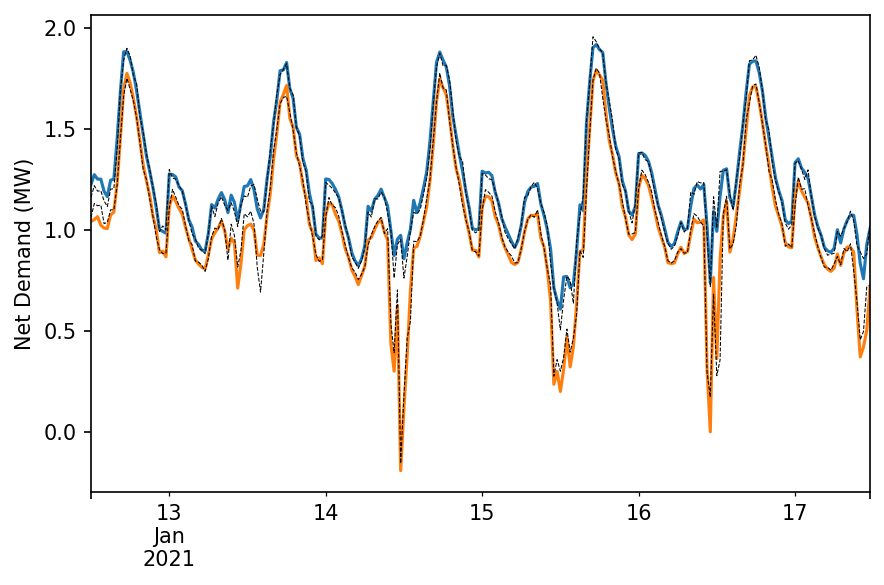

In [32]:
%%time

params = copy.deepcopy(default_params)


model_suite, error_metrics, df_pred, input_data = suite.run_parameterised_model(**params)
suite.plot_pred_sample(df_pred, df_target)

suite.calc_month_error_metrics(df_pred, df_target)

In [ ]:
# testing multi-output model 

In [31]:
%%time

params = copy.deepcopy(default_params)

params['model_1'] = 'sklearn.ensemble.RandomForestRegressor'
params['model_2'] = None
params['model_1_kwargs'] = {
    'n_estimators': 500,
}

model_suite, error_metrics, df_pred, input_data = suite.run_parameterised_model(**params)

error_metrics

Wall time: 1h 33min 2s


{'y1_rmse': 9.715272123579346,
 'y2_rmse': 10.840088662072487,
 'combined_rmse': 14.597033468601982,
 'skill_score': 0.4731857306511668}

In [ ]:
# testing akylas' model

In [ ]:
%%time

params = {
    'data_dir': '../data',
    'model_1': 'sklearn.ensemble.RandomForestRegressor',
    'model_2': None,
    'model_1_kwargs': {
        'n_estimators': 500,
    },
    'model_2_kwargs': {},
    'data_kwargs': {
        'real_power_sub_dir': 'real_power',
        'weather_sub_dir': 'weather',
        'real_power_time_period': '_pre_september',
        'real_power_site': 'Staplegrove_CB905',
        'weather_sites': ['staplegrove', 'mousehole'],
        'weather_grid_points': None,
        'weather_interpolate_method': 'interpolate',
        'use_target_delta': True
    },
    'y1_col': 'value_max',
    'y2_col': 'value_min',
    'split_kwargs': {
        'n_splits': 5, 
        'shuffle': False
    },
    'cols_subset': [
        'value',
        'temperature_staplegrove_1',
        'solar_irradiance_staplegrove_1',
        'pressure_staplegrove_1',
        'spec_humidity_staplegrove_1',
        'speed_staplegrove_1',
        'direction_staplegrove_1',
        'temperature_staplegrove_2',
        'solar_irradiance_staplegrove_2',
        'pressure_staplegrove_2',
        'spec_humidity_staplegrove_2',
        'speed_staplegrove_2',
        'direction_staplegrove_2',
        'temperature_staplegrove_3',
        'solar_irradiance_staplegrove_3',
        'pressure_staplegrove_3',
        'spec_humidity_staplegrove_3',
        'speed_staplegrove_3',
        'direction_staplegrove_3',
        'temperature_staplegrove_4',
        'solar_irradiance_staplegrove_4',
        'pressure_staplegrove_4',
        'spec_humidity_staplegrove_4',
        'speed_staplegrove_4',
        'direction_staplegrove_4',
        'temperature_staplegrove_5',
        'solar_irradiance_staplegrove_5',
        'pressure_staplegrove_5',
        'spec_humidity_staplegrove_5',
        'speed_staplegrove_5',
        'direction_staplegrove_5',
        'temperature_mousehole_1',
        'solar_irradiance_mousehole_1',
        'pressure_mousehole_1',
        'spec_humidity_mousehole_1',
        'speed_mousehole_1',
        'direction_mousehole_1',
        'temperature_mousehole_2',
        'solar_irradiance_mousehole_2',
        'pressure_mousehole_2',
        'spec_humidity_mousehole_2',
        'speed_mousehole_2',
        'direction_mousehole_2',
        'temperature_mousehole_3',
        'solar_irradiance_mousehole_3',
        'pressure_mousehole_3',
        'spec_humidity_mousehole_3',
        'speed_mousehole_3',
        'direction_mousehole_3',
        'temperature_mousehole_4',
        'solar_irradiance_mousehole_4',
        'pressure_mousehole_4',
        'spec_humidity_mousehole_4',
        'speed_mousehole_4',
        'direction_mousehole_4',
        'temperature_mousehole_5',
        'solar_irradiance_mousehole_5',
        'pressure_mousehole_5',
        'spec_humidity_mousehole_5',
        'speed_mousehole_5',
        'direction_mousehole_5',
        'solar_irradiance_staplegrove_max',
        'solar_irradiance_staplegrove_min',
        'solar_irradiance_staplegrove_mean',
        'solar_irradiance_staplegrove_range',
        'solar_irradiance_staplegrove_max___diff',
        'solar_irradiance_staplegrove_mean___diff',
        'solar_irradiance_staplegrove_max___ewm__alpha_0.9__mean',
        'solar_irradiance_staplegrove_mean___ewm__alpha_0.9__mean',
        'solar_irradiance_mousehole_max',
        'solar_irradiance_mousehole_min',
        'solar_irradiance_mousehole_mean',
        'solar_irradiance_mousehole_range',
        'solar_irradiance_mousehole_max___diff',
        'solar_irradiance_mousehole_mean___diff',
        'solar_irradiance_mousehole_max___ewm__alpha_0.9__mean',
        'solar_irradiance_mousehole_mean___ewm__alpha_0.9__mean',
        'month',
        'weekday',
        'hour',
        'weekend',
        'doy',
        'demand_pc1',
        'demand_pc2',
        'demand_pc3',
        'demand_pc4',
        'demand_pc5',
        'demand_pc6',
        'demand_pc7',
        'demand_pc8',
        'demand_pc9',
        'demand_pc10',
        'demand_pc11',
        'demand_pc12',
        'demand_pc13',
        'demand_pc14',
        'demand_pc15',
        'demand_pc16',
        'demand_pc17',
        'demand_pc18',
        'demand_pc19',
        'demand_pc20',
        'value_diff_1',
        'value_diff_2',
        'value_diff_3',
        'value_lag_1',
        'value_lag_2',
        'value_lag_3',
        'value_lag_4',
        'value_lag_5',
        'value_lag_6',
        'value_lag_48',
        'value_lag_96',
        'value_lag_336',
        'temperature_staplegrove_1_lag_1',
        'temperature_staplegrove_1_lag_2',
        'solar_irradiance_staplegrove_1_lag_1',
        'solar_irradiance_staplegrove_1_lag_2',
        'temperature_staplegrove_2_lag_1',
        'temperature_staplegrove_2_lag_2',
        'solar_irradiance_staplegrove_2_lag_1',
        'solar_irradiance_staplegrove_2_lag_2',
        'temperature_staplegrove_3_lag_1',
        'temperature_staplegrove_3_lag_2',
        'solar_irradiance_staplegrove_3_lag_1',
        'solar_irradiance_staplegrove_3_lag_2',
        'temperature_staplegrove_4_lag_1',
        'temperature_staplegrove_4_lag_2',
        'solar_irradiance_staplegrove_4_lag_1',
        'solar_irradiance_staplegrove_4_lag_2',
        'temperature_staplegrove_5_lag_1',
        'temperature_staplegrove_5_lag_2',
        'solar_irradiance_staplegrove_5_lag_1',
        'solar_irradiance_staplegrove_5_lag_2',
        'temperature_mousehole_1_lag_1',
        'temperature_mousehole_1_lag_2',
        'solar_irradiance_mousehole_1_lag_1',
        'solar_irradiance_mousehole_1_lag_2',
        'temperature_mousehole_2_lag_1',
        'temperature_mousehole_2_lag_2',
        'solar_irradiance_mousehole_2_lag_1',
        'solar_irradiance_mousehole_2_lag_2',
        'temperature_mousehole_3_lag_1',
        'temperature_mousehole_3_lag_2',
        'solar_irradiance_mousehole_3_lag_1',
        'solar_irradiance_mousehole_3_lag_2',
        'temperature_mousehole_4_lag_1',
        'temperature_mousehole_4_lag_2',
        'solar_irradiance_mousehole_4_lag_1',
        'solar_irradiance_mousehole_4_lag_2',
        'temperature_mousehole_5_lag_1',
        'temperature_mousehole_5_lag_2',
        'solar_irradiance_mousehole_5_lag_1',
        'solar_irradiance_mousehole_5_lag_2',
        'value___ewm__alpha_0.9__std',
        'value___ewm__alpha_0.9__mean',
        'value___ewm__alpha_0.01__mean',
        'value___rolling__window_24__min',
        'value___rolling__window_12__max'
    ],
    'features_kwargs': {
        'features': ['temporal', 'dir_speed', 'lagged', 'demand', 'solar', 'ts_pcs', 'roc'],
        'feature_lags': {
            'value': [1, 2, 3, 4, 5, 6, 48, 96, 336],
            'solar_irradiance_staplegrove_1': [1, 2],
            'solar_irradiance_staplegrove_2': [1, 2],
            'solar_irradiance_staplegrove_3': [1, 2],
            'solar_irradiance_staplegrove_4': [1, 2],
            'solar_irradiance_staplegrove_5': [1, 2],
            'solar_irradiance_mousehole_1': [1, 2],
            'solar_irradiance_mousehole_2': [1, 2],
            'solar_irradiance_mousehole_3': [1, 2],
            'solar_irradiance_mousehole_4': [1, 2],
            'solar_irradiance_mousehole_5': [1, 2],
            'temperature_mousehole_1': [1, 2],
            'temperature_mousehole_2': [1, 2],
            'temperature_mousehole_3': [1, 2],
            'temperature_mousehole_4': [1, 2],
            'temperature_mousehole_5': [1, 2],
            'temperature_staplegrove_1': [1, 2],
            'temperature_staplegrove_2': [1, 2],
            'temperature_staplegrove_3': [1, 2],
            'temperature_staplegrove_4': [1, 2],
            'temperature_staplegrove_5': [1, 2]
        },
        'roc_features': {
            'value': 3
        },
        'sites': ['staplegrove', 'mousehole'],
        'grid_points': None
    }
}

model_suite, error_metrics, df_pred, input_data = suite.run_parameterised_model(**params)

error_metrics

In [ ]:
suite.calc_month_error_metrics(df_pred, df_target)

In [ ]:
# Wall time: 6h 58min 59s
# {'y1_rmse': 13.14325597126152,
#  'y2_rmse': 14.50860434202291,
#  'combined_rmse': 19.58150340774188,
#  'skill_score': 0.6765334756353172}

In [ ]:
model_suite, error_metrics, df_pred, input_data = suite.run_parameterised_model(**params)

error_metrics

<br>

### Visualisations

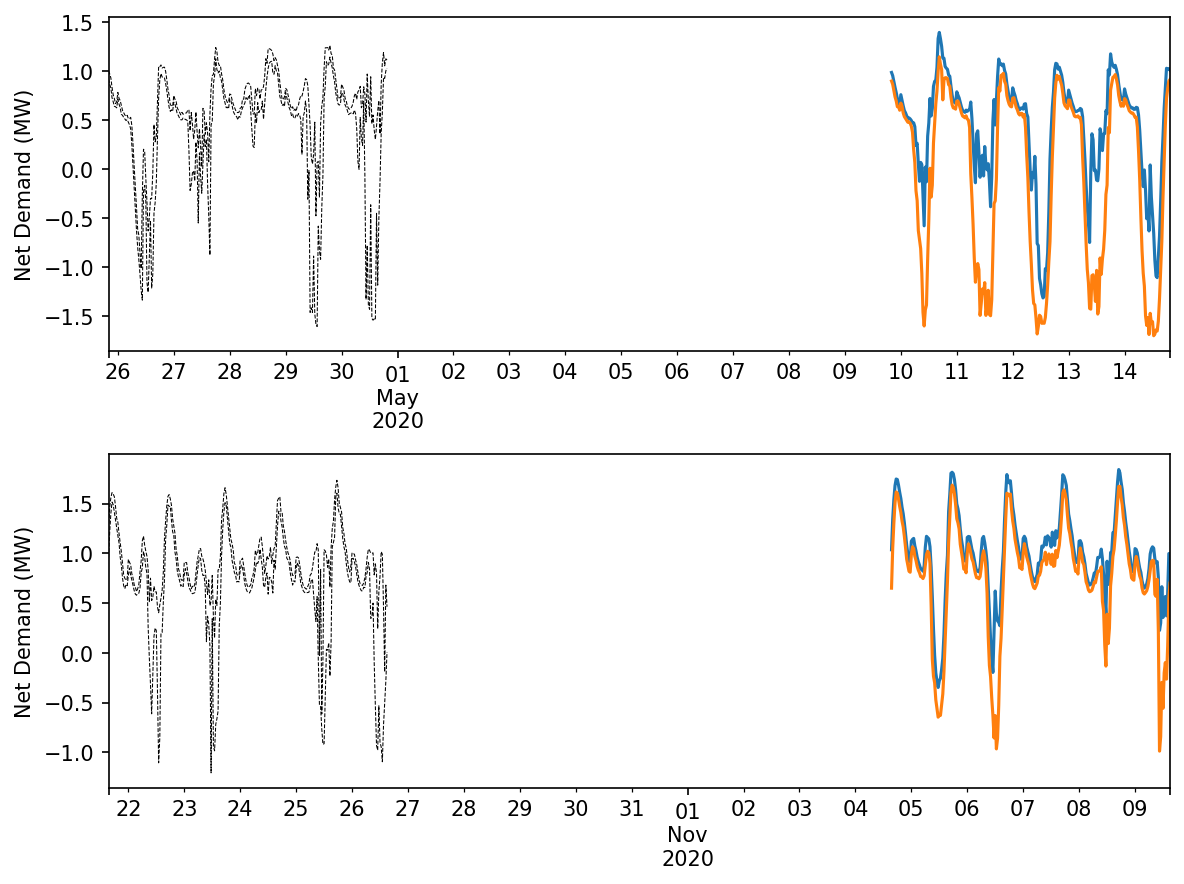

In [8]:
suite.plot_pred_sample(df_pred, df_target, subplot_kwargs={'figsize': (8, 6), 'dpi': 150, 'nrows': 2})

ValueError: x and y must be the same size

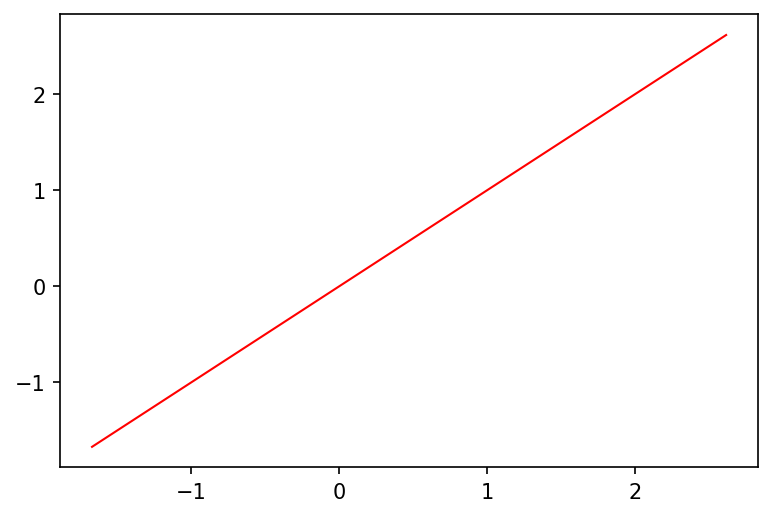

In [9]:
if df_target.index.tz is not None:
    df_target = df_target.pipe(lambda df: df.set_index(df.index.tz_convert(None)))
    
suite.visualise_errors(df_pred, df_target)

In [221]:
JSON(r_json)

<IPython.core.display.JSON object>

<AxesSubplot:xlabel='date'>

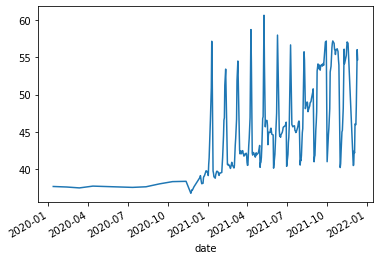

In [159]:
import requests

r_json = requests.get('https://europe-west1-vast-watch-230414.cloudfunctions.net/quote-ppa-price-index').json()

df = pd.DataFrame(r_json[0]['data'])
df['date'] = pd.to_datetime(df['date'])
df['value'] = df['value'].astype(float)

df.set_index('date').sort_index()['value'].plot()

<AxesSubplot:xlabel='date'>

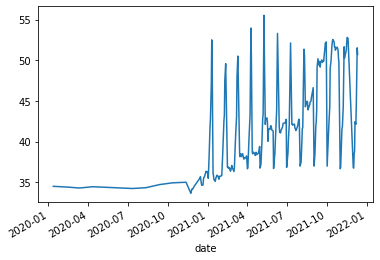

In [162]:
df = pd.DataFrame(r_json[1]['data'])
df['date'] = pd.to_datetime(df['date'])
df['value'] = df['value'].astype(float)

s = df.set_index('date').sort_index()['value']

s.plot()

<AxesSubplot:xlabel='date'>

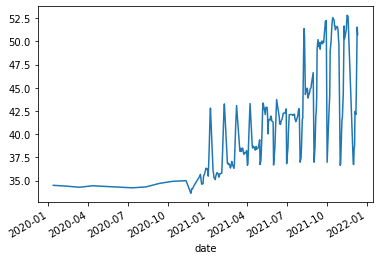

In [220]:
s_fine = ~pd.Series((s>45).values & (s.index < pd.to_datetime('2021-08-01')), index=s.index)

s[s_fine].plot()

<AxesSubplot:xlabel='value', ylabel='Count'>

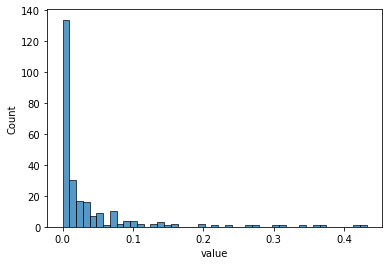

In [181]:
sns.histplot(s.diff().abs()/s)

In [168]:
JSON(r_json)

<IPython.core.display.JSON object>

In [167]:
s[s.diff().abs() > 5]

date
2021-01-10    52.51
2021-01-13    36.07
2021-02-15    36.85
2021-03-15    38.54
2021-04-10    53.97
2021-04-13    38.72
2021-05-10    55.54
2021-05-11    50.21
2021-05-13    42.11
2021-06-14    41.85
2021-07-01    36.82
2021-07-09    48.61
2021-07-13    42.12
2021-08-01    36.98
2021-08-09    48.86
2021-08-13    44.28
2021-09-02    36.98
2021-09-09    49.20
2021-10-02    36.97
2021-11-01    36.65
2021-11-10    51.66
2021-12-01    36.79
2021-12-10    51.53
Name: value, dtype: float64

<AxesSubplot:xlabel='date'>

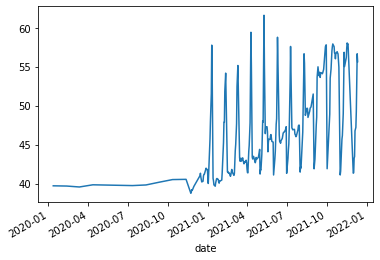

In [161]:
df = pd.DataFrame(r_json[2]['data'])
df['date'] = pd.to_datetime(df['date'])
df['value'] = df['value'].astype(float)

df.set_index('date').sort_index()['value'].plot()